# Combine MERFISH FICTURE results in spatialdata object
- create spatial data object
- add pixel level factors
- calculate transcript level factors

In [1]:
import gzip
import os

import dask.dataframe as dd
import numpy as np
import pandas as pd
import spatialdata
import spatialdata_io
from scipy.spatial import KDTree
from spatialdata.models import PointsModel

/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [2]:
data_dir = os.path.abspath("../data")

sdata_file = os.path.join(data_dir, "processed_data/FOXF2/SLIDE2/REGION1/sdata.zarr")
slide_name = "slide2"
region_name = "region1"

## Function definitions

In [3]:
def update_element(sdata, element_name):
    """Workaround for updating a backed element in sdata.
    Adapted from https://github.com/scverse/spatialdata/blob/main/tests/io/test_readwrite.py#L156
    """
    new_name = f"{element_name}_tmp"
    name = element_name
    # a a. write a backup copy of the data
    sdata[new_name] = sdata[name]
    sdata.write_element(new_name)
    # a2. remove the in-memory copy from the SpatialData object (note,
    # at this point the backup copy still exists on-disk)
    del sdata[new_name]
    del sdata[name]
    # a3 load the backup copy into memory
    sdata_copy = spatialdata.read_zarr(sdata.path)
    # b1. rewrite the original data
    sdata.delete_element_from_disk(name)
    sdata[name] = sdata_copy[new_name]
    sdata.write_element(name)
    # b2. reload the new data into memory (because it has been written but in-memory it still points
    # from the backup location)
    sdata = spatialdata.read_zarr(sdata.path)
    # c. remove the backup copy
    del sdata[new_name]
    sdata.delete_element_from_disk(new_name)

## 1. Create spatial data object
Will overwrite existing objects

In [3]:
# needed for "1. Create spatial data object"
merfish_results = os.path.join(
    data_dir, "merfish_output/20240322_mousebrain-Slide02-cp-WT-PCKO/region_1"
)

In [5]:
sdata = spatialdata_io.merscope(
    merfish_results,
    z_layers=None,
    cells_boundaries=True,
    mosaic_images=False,
    slide_name=slide_name,
    region_name=region_name,
)
# save sdata
os.makedirs(os.path.dirname(sdata_file), exist_ok=True)
sdata.write(sdata_file, overwrite=True)

INFO     The column "global_x" has now been renamed to "x"; the column "x" was already present in the dataframe,   
         and will be dropped.                                                                                      
INFO     The column "global_y" has now been renamed to "y"; the column "y" was already present in the dataframe,   
         and will be dropped.                                                                                      


/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/functools.py:926: UserWarning: The index of the dataframe is not monotonic increasing. It is recommended to sort the data to adjust the order of the index before calling .parse() (or call `parse(sort=True)`) to avoid possible problems due to unknown divisions.
  return method.__get__(obj, cls)(*args, **kwargs)
/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/hannah.spitzer/projects/cellseg_benchmark/st-bsb/data/processed_data/FOXF2/SLIDE2/REGION1/sdata.zar
         r                                                                                                         


## 2. Add pixel level factors

In [6]:
# needed for "2. Add pixel level factors and 3. Calculate transcript level factors"
# ficture_name = 'nF25_d5'
# pixel_level_factors_file = '/home/hspitzer/projects/cellseg_benchmark/data/ficture_output/r1/analysis/nF25.d_5/nF25.d_5.prj_6.r_4_5.pixel.sorted.tsv.gz'

ficture_name = "nF25_d6"
pixel_level_factors_file = os.path.join(
    data_dir,
    "ficture_input/REGION1/FICTURE/analysis/nF25.d_6/nF25.d_6.prj_6.r_4_5.pixel.sorted.tsv.gz",
)

In [7]:
sdata = spatialdata.read_zarr(sdata_file)

In [8]:
# read metadata
metadata = {}
with gzip.open(pixel_level_factors_file, "rb") as f:
    i = 0
    for line in f:
        line = line.decode()
        if i < 3:
            # read metadata from file
            for s in line.strip().strip("#").split(";"):
                k, v = s.split("=")
                metadata[k] = v
        if i == 3:
            break
        i += 1

metadata

{'K': '25',
 'TOPK': '3',
 'BLOCK_SIZE': '2000',
 'BLOCK_AXIS': 'X',
 'INDEX_AXIS': 'Y',
 'OFFSET_X': '173.92',
 'OFFSET_Y': '-47.43',
 'SIZE_X': '7065',
 'SIZE_Y': '5849',
 'SCALE': '100'}

In [9]:
# read data
df = pd.read_table(
    gzip.open(pixel_level_factors_file, "rb"), skiprows=3, header=0, engine="c"
)

# create um coords in df
scale = float(metadata["SCALE"])
offset_x = float(metadata["OFFSET_X"])
offset_y = float(metadata["OFFSET_Y"])

df["X_um"] = df["X"] / scale + offset_x
df["Y_um"] = df["Y"] / scale + offset_y

# sort for potentially more efficieny
df = df.sort_values(["X_um", "Y_um"])

# rename for adding to spatialdata
df = df.rename(columns={"X_um": "x", "Y_um": "y", "Y": "Y_px", "X": "X_px"})

In [10]:
# create dask dataframe
dask_df = dd.from_pandas(df, npartitions=96)
parsed = PointsModel.parse(dask_df)

In [11]:
parsed

,#BLOCK,X_px,Y_px,K1,K2,K3,P1,P2,P3,x,y
npartitions=96,,,,,,,,,,,
0,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64
960757,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
91271884,...,...,...,...,...,...,...,...,...,...,...
92232639,...,...,...,...,...,...,...,...,...,...,...


In [12]:
sdata[f"{slide_name}_{region_name}_{ficture_name}_pixel_factors"] = parsed

In [13]:
sdata

SpatialData object, with associated Zarr store: /Users/hannah.spitzer/projects/cellseg_benchmark/st-bsb/data/processed_data/FOXF2/SLIDE2/REGION1/sdata.zarr
├── Points
│     ├── 'slide2_region1_nF25_d6_pixel_factors': DataFrame with shape: (<Delayed>, 11) (2D points)
│     └── 'slide2_region1_transcripts': DataFrame with shape: (<Delayed>, 9) (2D points)
├── Shapes
│     └── 'slide2_region1_polygons': GeoDataFrame shape: (107013, 9) (2D shapes)
└── Tables
      └── 'table': AnnData (107013, 500)
with coordinate systems:
    ▸ 'global', with elements:
        slide2_region1_nF25_d6_pixel_factors (Points), slide2_region1_transcripts (Points), slide2_region1_polygons (Shapes)
with the following elements not in the Zarr store:
    ▸ slide2_region1_nF25_d6_pixel_factors (Points)

In [14]:
# update sdata
sdata.write_element(
    f"{slide_name}_{region_name}_{ficture_name}_pixel_factors", overwrite=True
)

## 3. Add transcript level factors

In [15]:
# set up KDTree for efficient querying
coords = np.array([df["x"], df["y"]]).T
tree = KDTree(
    coords, leafsize=10, compact_nodes=True, copy_data=False, balanced_tree=True
)

In [16]:
def get_transcript_level_factors(transcripts):
    # query tree to get nearest pixels and according factor assignment
    query = np.array([transcripts["x"], transcripts["y"]]).T
    dd, ii = tree.query(query)
    # get factor prediction from df
    factor = np.array(df.iloc[ii]["K1"])
    # where distance > 5 um set factor to max_factor to indicate that this transcript was not mapped
    factor[dd > 5] = int(metadata["K"])
    kwargs = {f"{ficture_name}_factors": factor}
    return transcripts.assign(**kwargs)


# calculate transcript_level_factors
res = sdata[f"{slide_name}_{region_name}_transcripts"].map_partitions(
    get_transcript_level_factors
)
# update transcripts table
sdata[f"{slide_name}_{region_name}_transcripts"] = res

/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `slide2_region1_transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [17]:
# update sdata (and calculate transcript level factors)
update_element(sdata, f"{slide_name}_{region_name}_transcripts")

In [18]:
sdata

SpatialData object, with associated Zarr store: /Users/hannah.spitzer/projects/cellseg_benchmark/st-bsb/data/processed_data/FOXF2/SLIDE2/REGION1/sdata.zarr
├── Points
│     ├── 'slide2_region1_nF25_d6_pixel_factors': DataFrame with shape: (<Delayed>, 11) (2D points)
│     └── 'slide2_region1_transcripts': DataFrame with shape: (<Delayed>, 10) (2D points)
├── Shapes
│     └── 'slide2_region1_polygons': GeoDataFrame shape: (107013, 9) (2D shapes)
└── Tables
      └── 'table': AnnData (107013, 500)
with coordinate systems:
    ▸ 'global', with elements:
        slide2_region1_nF25_d6_pixel_factors (Points), slide2_region1_transcripts (Points), slide2_region1_polygons (Shapes)

In [19]:
sdata[f"{slide_name}_{region_name}_transcripts"]

,x,y,gene,cell_id,transcript_id,fov,barcode_id,global_z,Unnamed: 0,nF25_d6_factors
npartitions=96,,,,,,,,,,
,float64,float64,category[known],int64,string,int64,int64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...


## Add images to spatialdata object

In [4]:
sdata = spatialdata.read_zarr(sdata_file)

### Mosaic images from merscope

In [5]:
def add_mosaic_images(sdata, path, z_layers=3):
    sdata_new = spatialdata_io.merscope(
        path,
        z_layers=z_layers,
        cells_boundaries=True,
        mosaic_images=True,
        slide_name=slide_name,
        region_name=region_name,
    )
    if isinstance(z_layers, int):
        z_layers = [z_layers]
    # add images to sdata
    for z in z_layers:
        sdata.images[f"{slide_name}_{region_name}_z{z}"] = sdata_new[
            f"{slide_name}_{region_name}_z{z}"
        ]
    return sdata

In [6]:
sdata = add_mosaic_images(sdata, merfish_results, z_layers=3)

INFO     The column "global_x" has now been renamed to "x"; the column "x" was already present in the dataframe,   
         and will be dropped.                                                                                      
INFO     The column "global_y" has now been renamed to "y"; the column "y" was already present in the dataframe,   
         and will be dropped.                                                                                      


/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/functools.py:926: UserWarning: The index of the dataframe is not monotonic increasing. It is recommended to sort the data to adjust the order of the index before calling .parse() (or call `parse(sort=True)`) to avoid possible problems due to unknown divisions.
  return method.__get__(obj, cls)(*args, **kwargs)
/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


KeyboardInterrupt: 

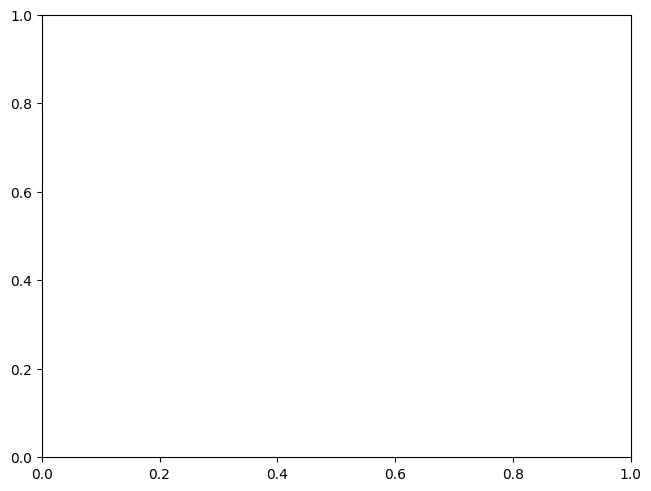

In [22]:
sdata.pl.render_images("slide2_region1_z3", scale="scale4").pl.show()

In [18]:
sdata["slide2_region1_z3"]["scale4"]["image"][0].compute()

<xarray.DataArray 'image' (y: 3403, x: 4104)> Size: 28MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
Coordinates:
    c        <U5 20B 'PolyT'
  * y        (y) float64 27kB 8.001 24.0 40.01 ... 5.442e+04 5.443e+04 5.445e+04
  * x        (x) float64 33kB 8.001 24.0 40.01 ... 6.563e+04 6.565e+04 6.567e+04
Attributes:
    transform:  {'global': Sequence \n    Scale (y, x)\n        [16.00235087 ...

In [19]:
sdata["slide2_region1_z3"]["scale4"]["image"][0]

<xarray.DataArray 'image' (y: 3403, x: 4104)> Size: 28MB
dask.array<getitem, shape=(3403, 4104), dtype=uint16, chunksize=(3403, 4096), chunktype=numpy.ndarray>
Coordinates:
    c        <U5 20B 'PolyT'
  * y        (y) float64 27kB 8.001 24.0 40.01 ... 5.442e+04 5.443e+04 5.445e+04
  * x        (x) float64 33kB 8.001 24.0 40.01 ... 6.563e+04 6.565e+04 6.567e+04
Attributes:
    transform:  {'global': Sequence \n    Scale (y, x)\n        [16.00235087 ...

### Ficture summary images 
need to figure out coordinate transfor for this!

## Plot

TODO: also plot images once they are downloaded - check again if shapes are visualised correctly

NOTE inconsistencies regarding plotting method - offset with `method="datashader"`` for render_shapes. Should report this as issue, but need to reproduce with their datsets first. For now, use method "matplotlib" instead

In [21]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [4]:
sdata = spatialdata.read_zarr(sdata_file)

In [24]:
sdata

SpatialData object, with associated Zarr store: /Users/hannah.spitzer/projects/cellseg_benchmark/st-bsb/data/processed_data/FOXF2/SLIDE2/REGION1/sdata.zarr
├── Points
│     ├── 'slide2_region1_nF25_d6_pixel_factors': DataFrame with shape: (<Delayed>, 11) (2D points)
│     ├── 'slide2_region1_transcripts': DataFrame with shape: (<Delayed>, 10) (2D points)
│     └── 'slide2_region1_transcripts_sub': DataFrame with shape: (<Delayed>, 10) (2D points)
├── Shapes
│     └── 'slide2_region1_polygons': GeoDataFrame shape: (107013, 9) (2D shapes)
└── Tables
      └── 'table': AnnData (107013, 500)
with coordinate systems:
    ▸ 'global', with elements:
        slide2_region1_nF25_d6_pixel_factors (Points), slide2_region1_transcripts (Points), slide2_region1_transcripts_sub (Points), slide2_region1_polygons (Shapes)
with the following elements not in the Zarr store:
    ▸ slide2_region1_transcripts_sub (Points)

In [22]:
# prepare factor labels for plotting

# convert factor labels to categories
sdata["slide2_region1_transcripts"].categorize(columns="nF25_d6_factors")

# get colormap for each factor
ficture_dex_file = os.path.join(
    data_dir,
    "ficture_input/REGION1/FICTURE/analysis/nF25.d_6/nF25.d_6.prj_6.r_4_5.factor.info.tsv",
)
ficture_dex = pd.read_table(ficture_dex_file)
factor_color_code = ficture_dex["RGB"]
colors = [
    [float(c) / 255 for c in factor_color_code[factor].split(",")]
    for factor in range(25)
]
cmap = ListedColormap(colors)

In [25]:
# subset transcripts for fast plotting
sdata["slide2_region1_transcripts_sub"] = sdata["slide2_region1_transcripts"].sample(
    frac=0.0001
)

/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `slide2_region1_transcripts_sub` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [70]:
sdata["slide2_region1_polygons_sub"] = sdata["slide2_region1_polygons"].sample(
    frac=0.0001
)

/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/spatialdata/_core/_elements.py:96: UserWarning: Key `slide2_region1_polygons_sub` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [8]:
# define bounding box for spatial query for high res plotting
bb_xmin = 10000
bb_ymin = 34000
bb_w = 3000
bb_h = 2000
bb_xmax = bb_xmin + bb_w
bb_ymax = bb_ymin + bb_h

/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `slide2_region1_transcripts_sub` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


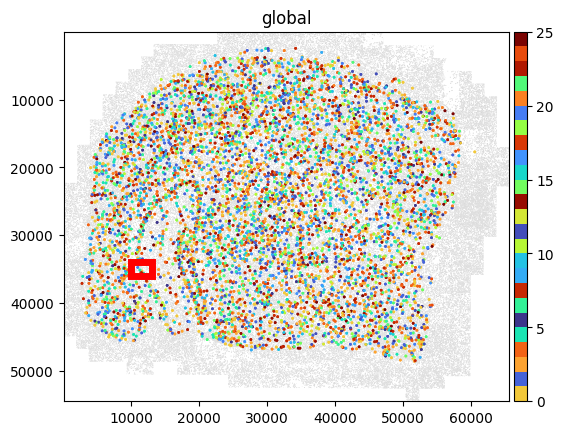

In [72]:
# plot cell segmentations and transcripts on whole slide
f, ax = plt.subplots()
sdata.pl.render_shapes(
    "slide2_region1_polygons", outline=True, method="matplotlib"
).pl.render_points(
    "slide2_region1_transcripts_sub", color="nF25_d6_factors", cmap=cmap
).pl.show(ax=ax)
rect = patches.Rectangle(
    (bb_xmin, bb_ymin), bb_w, bb_h, linewidth=5, edgecolor="red", facecolor="none"
)
ax.add_patch(rect)

In [9]:
# spatial crop of sdata to enable high-res plotting
cropped_sdata = sdata.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[bb_xmin, bb_ymin],
    max_coordinate=[bb_xmax, bb_ymax],
    target_coordinate_system="global",
)

cropped_sdata

SpatialData object
├── Images
│     └── 'slide2_region1_z3': DataTree[cyx] (7, 2000, 3000), (7, 1000, 1500), (7, 500, 750), (7, 250, 375), (7, 125, 187)
├── Points
│     └── 'slide2_region1_transcripts': DataFrame with shape: (<Delayed>, 10) (2D points)
├── Shapes
│     └── 'slide2_region1_polygons': GeoDataFrame shape: (229, 9) (2D shapes)
└── Tables
      └── 'table': AnnData (229, 500)
with coordinate systems:
    ▸ 'global', with elements:
        slide2_region1_z3 (Images), slide2_region1_transcripts (Points), slide2_region1_polygons (Shapes)

/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `slide2_region1_transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


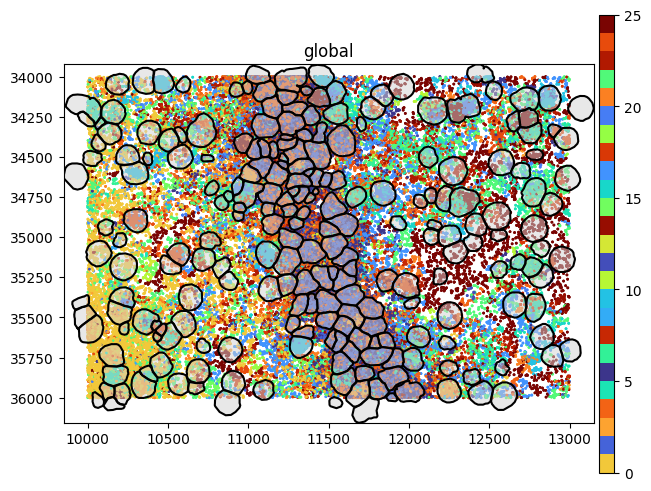

In [103]:
cropped_sdata.pl.render_points(
    "slide2_region1_transcripts",
    color="nF25_d6_factors",
    cmap=cmap,
    method="matplotlib",
).pl.render_shapes(
    "slide2_region1_polygons", outline_alpha=1, outline_color="black", fill_alpha=0.5
).pl.show()

In [12]:
cropped_sdata.pl.render_images("slide2_region1_z3").pl.show()

: 

: 

In [23]:
from napari_spatialdata import Interactive

In [24]:
interactive = Interactive(sdata)
interactive.run()

In [25]:
sdata

SpatialData object, with associated Zarr store: /Users/hannah.spitzer/projects/cellseg_benchmark/st-bsb/data/processed_data/FOXF2/SLIDE2/REGION1/sdata.zarr
├── Images
│     └── 'slide2_region1_z3': DataTree[cyx] (7, 54456, 65675), (7, 27228, 32837), (7, 13614, 16418), (7, 6807, 8209), (7, 3403, 4104)
├── Points
│     ├── 'slide2_region1_nF25_d6_pixel_factors': DataFrame with shape: (<Delayed>, 11) (2D points)
│     └── 'slide2_region1_transcripts': DataFrame with shape: (<Delayed>, 10) (2D points)
├── Shapes
│     └── 'slide2_region1_polygons': GeoDataFrame shape: (107013, 9) (2D shapes)
└── Tables
      └── 'table': AnnData (107013, 500)
with coordinate systems:
    ▸ 'global', with elements:
        slide2_region1_z3 (Images), slide2_region1_nF25_d6_pixel_factors (Points), slide2_region1_transcripts (Points), slide2_region1_polygons (Shapes)
with the following elements not in the Zarr store:
    ▸ slide2_region1_z3 (Images)

2025-01-14 11:56:32.623 | INFO     | napari_spatialdata._view:_on_layer_update:357 - Updating layer.
2025-01-14 11:56:32.894 | INFO     | napari_spatialdata._view:_on_layer_update:357 - Updating layer.
2025-01-14 12:00:09.625 | INFO     | napari_spatialdata._view:_on_layer_update:357 - Updating layer.
2025-01-14 12:00:09.648 | INFO     | napari_spatialdata._view:_on_layer_update:357 - Updating layer.
2025-01-14 12:00:09.652 | INFO     | napari_spatialdata._view:_on_layer_update:357 - Updating layer.


: 

In [10]:
merfish_sdata = spatialdata.read_zarr("/Users/hannah.spitzer/Downloads/data.zarr")

In [73]:
merfish_sdata.points["single_molecule"] = merfish_sdata.points[
    "single_molecule"
].sample(frac=0.01)

/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `single_molecule` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `single_molecule` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/spatialdata_plot/pl/utils.py:781: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired valu

INFO     Using 'datashader' backend with 'sum' as reduction method to speed up plotting. Depending on the reduction
         method, the value range of the plot might change. Set method to 'matplotlib' do disable this behaviour.   


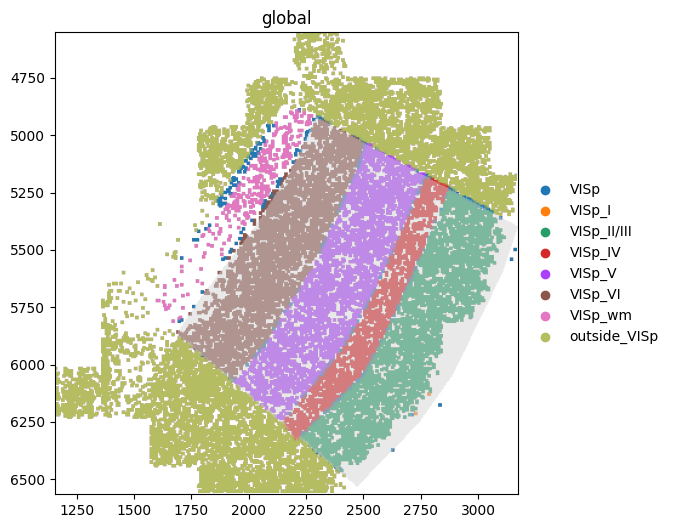

In [100]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))

(
    merfish_sdata.subset(["anatomical", "rasterized", "single_molecule"])
    .pl.render_points(color="cell_type", size=1, method="datashader")
    .pl.render_shapes(fill_alpha=0.5, outline=True, method="datashader")
    .pl.show(ax=ax)
)

/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `single_molecule` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/spatialdata_plot/pl/utils.py:781: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired valu

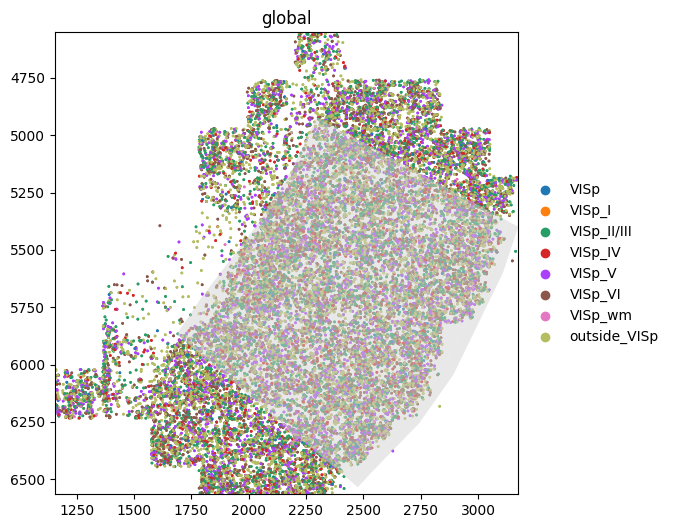

In [99]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))

(
    merfish_sdata.subset(["anatomical", "rasterized", "single_molecule"])
    .pl.render_points(color="cell_type", size=1, method="matplotlib")
    .pl.render_shapes(fill_alpha=0.5, outline=True, method="matplotlib")
    .pl.show(ax=ax)
)

In [13]:
merfish_sdata["single_molecule"]

,x,y,cell_type
npartitions=1,,,
,float64,float64,category[unknown]
,...,...,...


In [16]:
merfish_sdata["table"].uns["spatialdata_attrs"]

{'instance_key': 'cell_id', 'region': 'cells', 'region_key': 'region'}

In [78]:
blobs_sdata = spatialdata.datasets.blobs()

/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/spatialdata/models/models.py:1048: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)


In [79]:
blobs_sdata

SpatialData object
├── Images
│     ├── 'blobs_image': DataArray[cyx] (3, 512, 512)
│     └── 'blobs_multiscale_image': DataTree[cyx] (3, 512, 512), (3, 256, 256), (3, 128, 128)
├── Labels
│     ├── 'blobs_labels': DataArray[yx] (512, 512)
│     └── 'blobs_multiscale_labels': DataTree[yx] (512, 512), (256, 256), (128, 128)
├── Points
│     └── 'blobs_points': DataFrame with shape: (<Delayed>, 4) (2D points)
├── Shapes
│     ├── 'blobs_circles': GeoDataFrame shape: (5, 2) (2D shapes)
│     ├── 'blobs_multipolygons': GeoDataFrame shape: (2, 1) (2D shapes)
│     └── 'blobs_polygons': GeoDataFrame shape: (5, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (26, 3)
with coordinate systems:
    ▸ 'global', with elements:
        blobs_image (Images), blobs_multiscale_image (Images), blobs_labels (Labels), blobs_multiscale_labels (Labels), blobs_points (Points), blobs_circles (Shapes), blobs_multipolygons (Shapes), blobs_polygons (Shapes)

In [84]:
blobs_sdata["blobs_circles"]

,geometry,radius
0,POINT (291.062 197.065),51
1,POINT (259.026 371.319),51
2,POINT (194.973 204.414),51
3,POINT (149.926 188.623),51
4,POINT (369.422 258.9),51


INFO     Using 'datashader' backend with 'sum' as reduction method to speed up plotting. Depending on the reduction
         method, the value range of the plot might change. Set method to 'matplotlib' do disable this behaviour.   


/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `blobs_points` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/spatialdata_plot/pl/utils.py:781: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value t

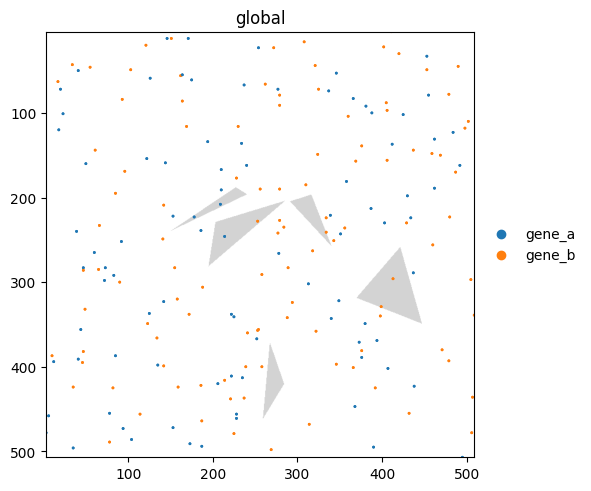

In [104]:
blobs_sdata.pl.render_shapes("blobs_polygons", method="datashader").pl.render_points(
    color="genes"
).pl.show()

/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `blobs_points` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/hannah.spitzer/miniconda3/envs/cellseg/lib/python3.10/site-packages/spatialdata_plot/pl/utils.py:781: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value t

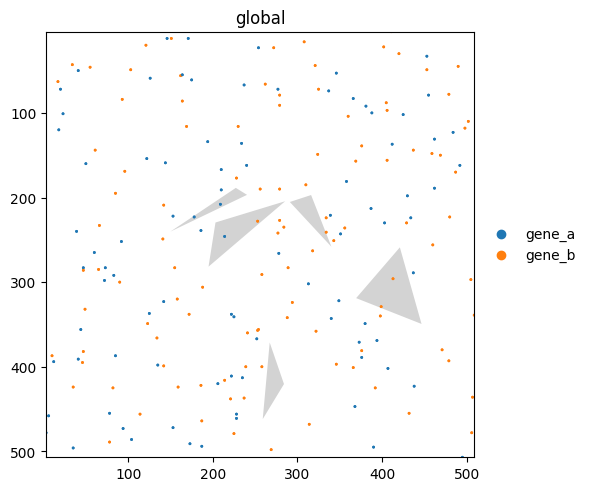

In [105]:
blobs_sdata.pl.render_shapes("blobs_polygons").pl.render_points(color="genes").pl.show()